## Module 4 Final Project Submission - Computer Vision

* Student name: Emily J. Cain
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL: https://medium.com/@magicmilly


#### Here I will write about my awesome project and why it's important

## I. Load & Organize Data
## II. Inspection & Exploratory Data Analysis
## III. Preprocessing
## IV. Modeling 
## V. Model Evaluation
## VI. Conclusions & Recommendations

In [ ]:
# Notes to myself
# styling - collapsible cells that I don't need to run (which might be most of them. . . )
# hyperlinks 

In [7]:
import cv2
import datetime
import h5py
import numpy as np
import os
# import pandas as pd
# import random
# import scipy
# import shutil
# import time
import warnings
# import zipfile

from keras import optimizers
from keras.applications import VGG16, VGG19
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical 
from matplotlib.pyplot import imshow
# from PIL import Image
# from scipy import ndimage
# from skimage.io import imread 
# from skimage.transform import resize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline
warnings.filterwarnings(action='ignore', category=FutureWarning)

# start = datetime.datetime.now()

## I. Load & Organize Data

In [2]:
# calculate amount of images
cnv_imgs = len(os.listdir('Data/cnv'))
dme_imgs = len(os.listdir('Data/dme'))
drusen_imgs = len(os.listdir('Data/drusen'))
normal_imgs = len(os.listdir('Data/normal'))

total_imgs = cnv_imgs + dme_imgs + drusen_imgs + normal_imgs
print(f'There are {total_imgs} total images.')

There are 83606 total images.


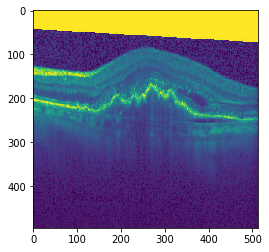

In [3]:
# inspect an original image
test_img = Image.open('Data/cnv/CNV-6294785-1.jpeg')
# test_img.show() - this opens image in new window
imshow(np.asarray(test_img)); # imshow for inline image

#### Resize and label images

In [ ]:
# img_classes = ['normal', 'cnv', 'dme', 'drusen']
# img_size = 40
# original_dir = 'Data'

# # keep myself from re-creating this list unnecessarily 
# try:
#     data = data
#     print('Data already exists in this dimension')
#     print(len(data))
# except NameError: 
#     data = None
#     print('Re-loading images')

# if data is None:
#     data = []
#     for img_class in img_classes:

#         path = os.path.join(original_dir, img_class)
#         # assign numeric value to class labels
#         class_num = img_classes.index(img_class)

#         for img in os.listdir(path):

#             file = os.path.join(path, img)
#             # if-else keeps .DS_store from throwing an error
#             if file.endswith('.jpeg'):
#                 img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                 # resize images to (40,40)
#                 resize_array = cv2.resize(img_array, (img_size, img_size))
#                 # create new data list of resized images with their class labels
#                 data.append([resize_array, class_num])
#             else:
#                 print(file)

In [6]:
# np.save('./Data/img_array', data)

In [8]:
# data = np.array(data)
# jupyter nbextension enable codefolding/main

In [9]:
data.shape

(83605, 2)

In [2]:
db = np.load("./Data/img_array.npy")
db.shape
# data.shape
db[0][1]
# data[0]

0

In [3]:
db.shape

(83605, 2)

In [4]:
db[0][0]

array([[255, 255, 255, ...,  19,   8,  16],
       [255, 255, 255, ...,  24,  26,  13],
       [255,  57,  25, ...,  18,  16,   3],
       ...,
       [  6,   3,  11, ...,   7,   2, 124],
       [  4,   9,   5, ..., 255, 255, 255],
       [  1,   9,   5, ..., 255, 255, 255]], dtype=uint8)

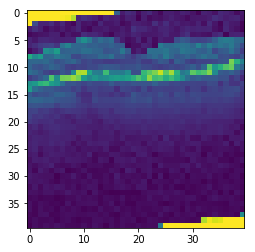

In [11]:
imshow(db[0][0]);

In [14]:
data[0][0].shape

(40, 40)

In [15]:
data[0].shape

(2,)

In [5]:
for feature, label in db:
    print(feature)
    print(label)
    print(type(feature))
    break

[[255 255 255 ...  19   8  16]
 [255 255 255 ...  24  26  13]
 [255  57  25 ...  18  16   3]
 ...
 [  6   3  11 ...   7   2 124]
 [  4   9   5 ... 255 255 255]
 [  1   9   5 ... 255 255 255]]
0
<class 'numpy.ndarray'>


In [19]:
X = []
y = []

for feature, label in db:
    # normalize image values by max value of 255
    X.append(feature/255)
    y.append(label)

In [15]:
len(X)

83605

In [16]:
len(y)

83605

In [8]:
print(X[1])

[[1.         1.         1.         ... 0.10980392 0.12156863 0.01568627]
 [0.05490196 0.18039216 0.19215686 ... 0.05490196 0.01176471 0.07058824]
 [0.14509804 0.07058824 0.18431373 ... 0.10588235 0.07058824 0.14901961]
 ...
 [0.05490196 0.07058824 0.06666667 ... 0.05490196 0.08235294 0.04313725]
 [0.07058824 0.05098039 0.0745098  ... 0.03529412 0.05098039 0.02745098]
 [0.06666667 0.06666667 0.02352941 ... 1.         1.         1.        ]]


In [18]:
print(y[1])

0


In [9]:
# reshape features for modeling
img_size = 40
X = np.array(X).reshape(-1, img_size, img_size, 1)

In [21]:
print(y[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
y = to_categorical(y, num_classes=4)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=0.2)

In [30]:
X.shape

(83605, 40, 40, 1)

In [31]:
y.shape

(83605, 4)

In [35]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=X.shape[1:], activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (4,4), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Flatten() because Dense layers only like 1D data
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [37]:
start = datetime.datetime.now()

# batch_size default = 32
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)
elapsed = datetime.datetime.now() - start
print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/30
53507/53507 [==============================] - 58s 1ms/step - loss: 0.7637 - acc: 0.7091 - val_loss: 0.5662 - val_acc: 0.7889
Epoch 2/30
53507/53507 [==============================] - 57s 1ms/step - loss: 0.5258 - acc: 0.8058 - val_loss: 0.4756 - val_acc: 0.8238
Epoch 3/30
53507/53507 [==============================] - 54s 1ms/step - loss: 0.4472 - acc: 0.8366 - val_loss: 0.4626 - val_acc: 0.8343
Epoch 4/30
53507/53507 [==============================] - 56s 1ms/step - loss: 0.3993 - acc: 0.8549 - val_loss: 0.4218 - val_acc: 0.8440
Epoch 5/30
53507/53507 [==============================] - 55s 1ms/step - loss: 0.3654 - acc: 0.8672 - val_loss: 0.3893 - val_acc: 0.8562
Epoch 6/30
53507/53507 [==============================] - 55s 1ms/step - loss: 0.3366 - acc: 0.8783 - val_loss: 0.3836 - val_acc: 0.8626
Epoch 7/30
53507/53507 [==============================] - 56s 1ms/step - loss: 0.3126 - acc: 0.8862 - val_loss: 0.3889 - val_acc

In [41]:
def print_metrics(model, X_train, y_train, X_test, y_test):
    print(f'Training loss: {model.evaluate(X_train, y_train)[0]}')
    print(f'Training accuracy: {model.evaluate(X_train, y_train)[1]}')
    print(f'Test loss: {model.evaluate(X_test, y_test)[0]}')
    print(f'Test accuracy: {model.evaluate(X_test, y_test)[1]}')

In [42]:
print_metrics(model, X_train, y_train, X_test, y_test)

66884/66884 [==============================] - 17s 253us/step
Training loss: 0.21424882945278623
66884/66884 [==============================] - 17s 253us/step
Training accuracy: 0.9441121942467556
16721/16721 [==============================] - 4s 259us/step
Test loss: 0.7160191144626018
16721/16721 [==============================] - 4s 259us/step
Test accuracy: 0.8564679146019738


In [39]:
model.evaluate(X_train, y_train)

66884/66884 [==============================] - 17s 255us/step


[0.21424882945278623, 0.9441121942467556]

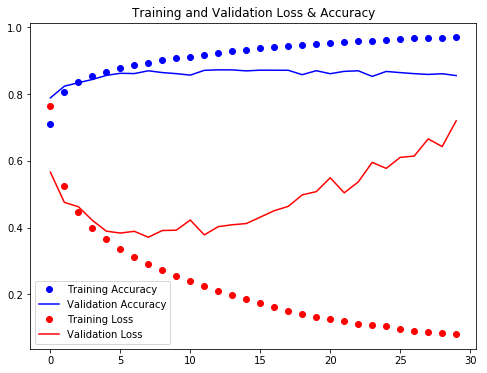

In [52]:
# Plot history - loss vs. accuracy
fig = plt.figure(figsize=(8,6))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# 'bo' is blue circle
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss & Accuracy')
plt.legend()
plt.show()

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        16416     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
__________

In [53]:
# model.save('Models/first_model_no_tuning.h5')

In [ ]:
# Ideas for optimizing model performance
# Reduce LR on plateau callback
# Early stopping
# Dropout


#### Try Using a Pre-trained Model Correctly this time, with Feature Extraction

In [24]:
# img_classes = ['normal', 'cnv', 'dme', 'drusen']
# rgb_img_size = 40
# original_dir = 'Data'

# # keep myself from re-creating this list unnecessarily 
# # try:
# #     rgb_data = rgb_data
# #     print('Colored data already exists in this dimension')
# #     print(len(rgb_data))
# # except NameError: 
# #     rgb_data = None
# #     print('Re-loading images')

# # if rgb_data is None:
# rgb_data = []
# for img_class in img_classes:

#     path = os.path.join(original_dir, img_class)
#     # assign numeric value to class labels
#     class_num = img_classes.index(img_class)

#     for img in os.listdir(path):

#         file = os.path.join(path, img)
#         # if-else keeps .DS_store from throwing an error
#         if file.endswith('.jpeg'):
#             img_array = cv2.imread(os.path.join(path, img))
#             # resize images to (64,64)
#             resize_array = cv2.resize(img_array, (rgb_img_size, rgb_img_size))
#             # create new data list of resized images with their class labels
#             rgb_data.append([resize_array, class_num])
#         else:
#             print(file)

Data/normal/.DS_Store


In [ ]:
# np.save('./Data/smaller_rgb', rgb_data)

In [25]:
# X = []
# y = []

# for feature, label in rgb_data:
#     # normalize image values by max value of 255
#     X.append(feature/255)
#     y.append(label)

In [26]:
# X = np.array(X).reshape(-1, 40, 40, 3)

In [27]:
# y = to_categorical(y, num_classes=4)

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=0.2)

In [29]:
# X_train.shape

(66884, 40, 40, 3)

In [30]:
# X_test.shape

(16721, 40, 40, 3)

In [ ]:
# datagen = ImageDataGenerator()
# batch_size = 

In [13]:
# function from lab

# def extract_features(directory, sample_amount):
#     features = np.zeros(shape=(sample_amount, 2, 2, 512)) 
#     labels = np.zeros(shape=(sample_amount))
#     generator = datagen.flow_from_directory(
#         directory, target_size=(64, 64), 
#         batch_size = 10, 
#         class_mode='binary')
#     i=0
#     for inputs_batch, labels_batch in generator:
#         features_batch = cnn_base.predict(inputs_batch)
#         features[i * batch_size : (i + 1) * batch_size] = features_batch 
#         labels[i * batch_size : (i + 1) * batch_size] = labels_batch
#         i = i + 1
#         if i * batch_size >= sample_amount:
#             break
#     return features, labels

(83605, 4)

In [31]:
# v66_19_base = VGG19(weights='imagenet', include_top=False, input_shape=(40, 40, 3))

## Stuff that Definitely did not Work
aka I didn't know what I was doing

#### Create new RBG images for pre-trained networks which require 3 channels

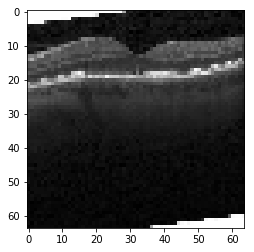

In [61]:
imshow(rgb_data[0][0]);

In [57]:
# img_classes = ['normal', 'cnv', 'dme', 'drusen']
# rgb_img_size = 64
# original_dir = 'Data'

# # keep myself from re-creating this list unnecessarily 
# try:
#     rgb_data = rgb_data
#     print('Larger, colored data already exists in this dimension')
#     print(len(rgb_data))
# except NameError: 
#     rgb_data = None
#     print('Re-loading images')

# if rgb_data is None:
#     rgb_data = []
#     for img_class in img_classes:

#         path = os.path.join(original_dir, img_class)
#         # assign numeric value to class labels
#         class_num = img_classes.index(img_class)

#         for img in os.listdir(path):

#             file = os.path.join(path, img)
#             # if-else keeps .DS_store from throwing an error
#             if file.endswith('.jpeg'):
#                 img_array = cv2.imread(os.path.join(path, img))
#                 # resize images to (64,64)
#                 resize_array = cv2.resize(img_array, (rgb_img_size, rgb_img_size))
#                 # create new data list of resized images with their class labels
#                 rgb_data.append([resize_array, class_num])
#             else:
#                 print(file)

Re-loading images
Data/normal/.DS_Store


In [59]:
len(rgb_data)

83605

In [60]:
# np.save('./Data/larger_rgb_img_array', rgb_data)

In [62]:
# WHY IS IT GRAYSCALE WHEN I WANT IT TO BE COLOR, AND IT WAS COLOR WHEN I WANTED IT TO BE GRAYSCALE?!?!?!

In [63]:
rgb_data = np.array(rgb_data)

In [65]:
X = []
y = []

for feature, label in rgb_data:
    X.append(feature/255)
    y.append(label)

In [68]:
X = np.array(X).reshape(-1, rgb_img_size, rgb_img_size, 3)
y = to_categorical(y, num_classes=4)

In [69]:
print(X.shape)
print(y.shape)

(83605, 64, 64, 3)
(83605, 4)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19, test_size=0.2)

In [71]:
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

In [72]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [73]:
model = Sequential()
model.add(cnn_base)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [74]:
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 True
flatten_4 True
dense_7 True
dense_8 True


In [75]:
# freeze cnn base and recheck

cnn_base.trainable = False
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_4 True
dense_7 True
dense_8 True


In [76]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [77]:
# start = datetime.datetime.now()

# model.fit(X_train, y_train, epochs=10, validation_split=0.2)
# elapsed = datetime.datetime.now() - start
# print(f'Time elapsed: {elapsed}')

Train on 53507 samples, validate on 13377 samples
Epoch 1/10
53507/53507 [==============================] - 1617s 30ms/step - loss: 0.8691 - acc: 0.6603 - val_loss: 0.7929 - val_acc: 0.6966
Epoch 2/10
53507/53507 [==============================] - 1507s 28ms/step - loss: 0.7538 - acc: 0.7102 - val_loss: 0.8290 - val_acc: 0.6850
Epoch 3/10
53507/53507 [==============================] - 1453s 27ms/step - loss: 0.7128 - acc: 0.7264 - val_loss: 0.7220 - val_acc: 0.7197
Epoch 4/10
53507/53507 [==============================] - 1433s 27ms/step - loss: 0.6874 - acc: 0.7384 - val_loss: 0.7191 - val_acc: 0.7265
Epoch 5/10
53507/53507 [==============================] - 1508s 28ms/step - loss: 0.6709 - acc: 0.7432 - val_loss: 0.6981 - val_acc: 0.7319
Epoch 6/10
53507/53507 [==============================] - 1491s 28ms/step - loss: 0.6559 - acc: 0.7494 - val_loss: 0.7129 - val_acc: 0.7297
Epoch 7/10
53507/53507 [==============================] - 1528s 29ms/step - loss: 0.6442 - acc: 0.7544 - val_l

In [78]:
# this model performs significantly worse than the previous model and not just because it trained for only 10 epochs
# the previous model already had a training accuracy of above 90% at 10 epochs and a validation accuracy of 86%
# though the training and val acc for this model are almost the same, indicating goodness of fit

In [ ]:
# after 10 epochs, this model built on vgg19 had a training loss of 61%, training acc of 77%
# val_loss of 65%, val_acc of 75%

In [83]:
# model.save('Models/vgg19_10_epochs.h5')